In [1]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [2]:
print("TensorFlow version:", tf.__version__)
device_name = tf.test.gpu_device_name()
print('GPU found:' if device_name else 'No GPU found', device_name)
np.random.seed(42)
tf.random.set_seed(42)


TensorFlow version: 2.19.0
GPU found: /device:GPU:0


In [3]:
import tensorflow as tf
import pathlib
import numpy as np

DATASET_PATH = "data/mini_speech_commands_extracted/mini_speech_commands"
data_dir = pathlib.Path(DATASET_PATH)

if not data_dir.exists():
    tf.keras.utils.get_file(
        fname='mini_speech_commands.zip',
        origin='http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip',
        extract=True,
        cache_dir='.',
        cache_subdir='data'
    )


182082353/182082353 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Available commands:', commands)


Available commands: ['yes' 'right' 'go' 'down' 'no' 'up' 'left' 'stop']


In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav')
filenames = np.array(filenames)
print('Number of total examples:', len(filenames))


Number of total examples: 8000


In [6]:
train_files, test_files = train_test_split(filenames, test_size=0.2, random_state=42)
val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)
print('Training samples:', len(train_files))
print('Validation samples:', len(val_files))
print('Testing samples:', len(test_files))


Training samples: 6400
Validation samples: 800
Testing samples: 800


In [7]:
def extract_features(file_path):
    audio, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40, hop_length=160, n_fft=512)
    max_len = 98
    if mfcc.shape[1] < max_len:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc


In [8]:
X, y = [], []
for file in train_files:
    label = file.split('/')[-2]
    features = extract_features(file)
    X.append(features)
    y.append(label)
X = np.array(X)
y = np.array(y)


In [9]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
commands = label_encoder.classes_
print('Encoded classes:', commands)


Encoded classes: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [10]:
X = X[..., np.newaxis]  # Add a channel dimension for CNN
print(X.shape)


(6400, 40, 98, 1)


In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(40, 98, 1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(commands), activation='softmax')
])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 96, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 46, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 23, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11776)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,507,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,546,056 (5.90 MB)

 Trainable params: 1,546,056 (5.90 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [13]:
history = model.fit(
    X, y_encoded,
    epochs=30,
    batch_size=100,
    validation_split=0.2
)


Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.1243 - loss: 14.0898 - val_accuracy: 0.1219 - val_loss: 2.0799
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1344 - loss: 2.0878 - val_accuracy: 0.1633 - val_loss: 2.0544
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1703 - loss: 2.0469 - val_accuracy: 0.2133 - val_loss: 2.0175
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2167 - loss: 1.9687 - val_accuracy: 0.3547 - val_loss: 1.7698
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3387 - loss: 1.7663 - val_accuracy: 0.4266 - val_loss: 1.6026
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4109 - loss: 1.6050 - val_accuracy: 0.4727 - val_loss: 1.4821
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4759 - loss: 1.4355 - val_accuracy: 0.4797 - val_loss: 1.4117
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5002 - loss: 1.3758 - val_accuracy: 0.5125 -

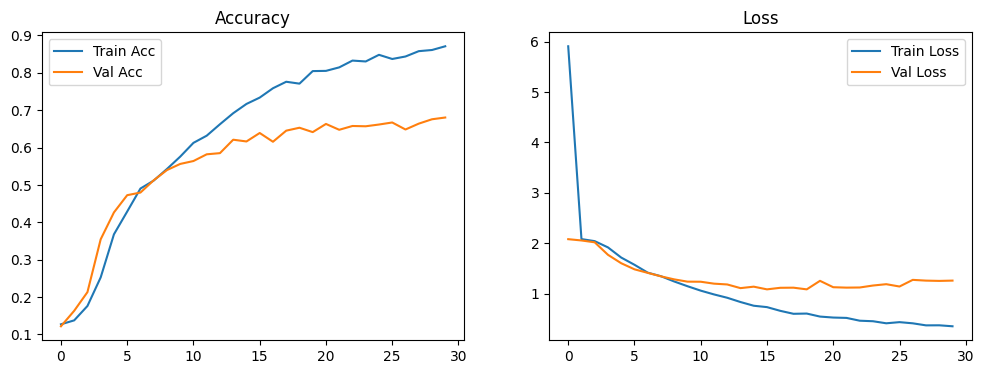

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [15]:
# Extract and preprocess test files similar to training
# Evaluate model performance
test_loss, test_acc = model.evaluate(X, y_encoded)
print('Test accuracy:', test_acc)


200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9830 - loss: 0.0918
Test accuracy: 0.9279687404632568


In [16]:
# --- Cell 16: Generate Predictions on Test Data ---
# If you have test_ds (TensorFlow dataset), convert it to arrays:
X_test, y_test = [], []
for file in test_files:
    label = file.split('/')[-2]
    features = extract_features(file)
    X_test.append(features)
    y_test.append(label)

X_test = np.array(X_test)[..., np.newaxis]
y_test = np.array(y_test)

# Encode test labels using the same encoder
y_test_encoded = label_encoder.transform(y_test)

# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


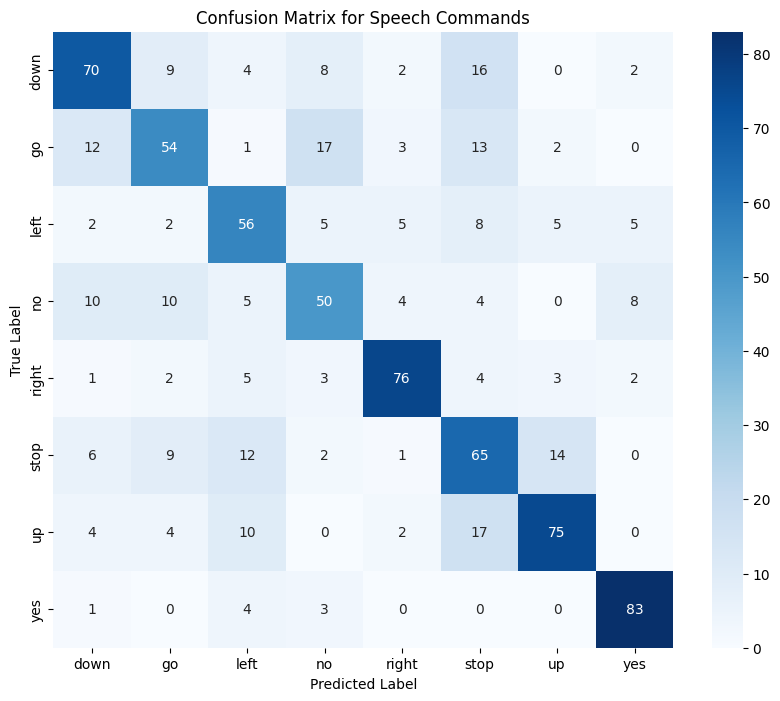

Classification Report:
               precision    recall  f1-score   support

        down       0.66      0.63      0.65       111
          go       0.60      0.53      0.56       102
        left       0.58      0.64      0.61        88
          no       0.57      0.55      0.56        91
       right       0.82      0.79      0.80        96
        stop       0.51      0.60      0.55       109
          up       0.76      0.67      0.71       112
         yes       0.83      0.91      0.87        91

    accuracy                           0.66       800
   macro avg       0.67      0.66      0.66       800
weighted avg       0.66      0.66      0.66       800



In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=commands, yticklabels=commands)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Speech Commands')
plt.show()

# Optional: show precision, recall, F1
print("Classification Report:\n", classification_report(y_test_encoded, y_pred, target_names=commands))


/tmp/ipython-input-2770807096.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=commands, y=class_acc, palette='viridis')


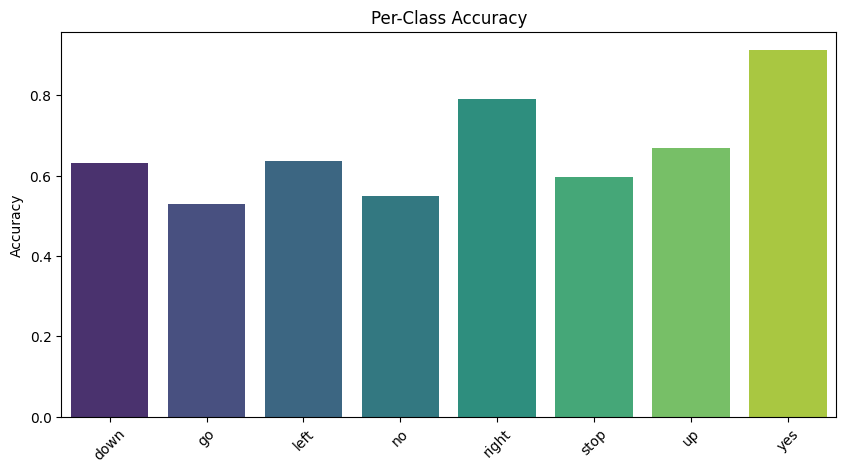

In [18]:
# Calculate per-class accuracy
cm_sum = np.sum(cm, axis=1, keepdims=True)
class_acc = cm.diagonal() / cm_sum.flatten()

plt.figure(figsize=(10, 5))
sns.barplot(x=commands, y=class_acc, palette='viridis')
plt.title('Per-Class Accuracy')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()


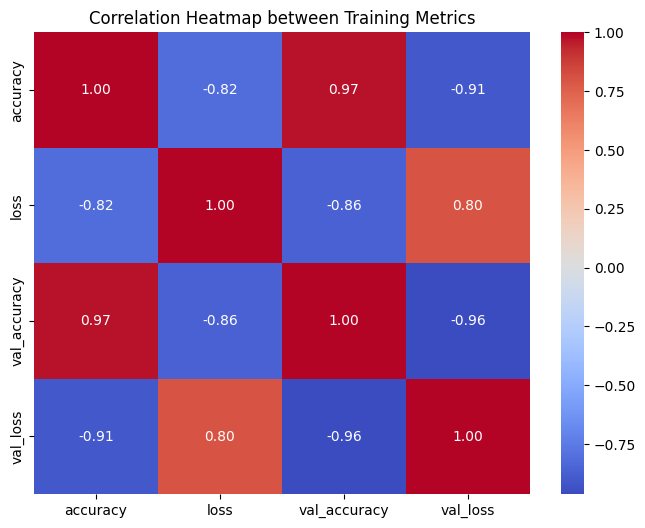

In [19]:
# Create a dataframe of accuracy/loss progression
import pandas as pd

history_df = pd.DataFrame(history.history)
plt.figure(figsize=(8, 6))
sns.heatmap(history_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between Training Metrics')
plt.show()


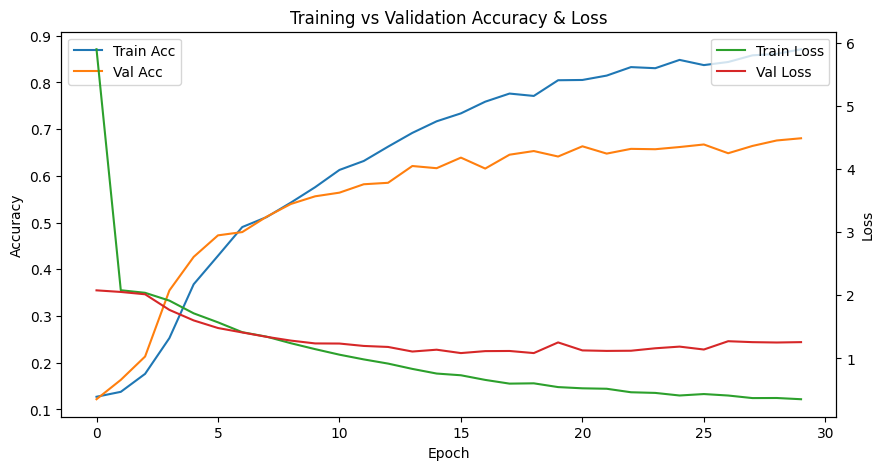

In [20]:
# Final comparison plot (Accuracy vs Loss)
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(history.history['accuracy'], label='Train Acc', color='tab:blue')
ax1.plot(history.history['val_accuracy'], label='Val Acc', color='tab:orange')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(history.history['loss'], label='Train Loss', color='tab:green')
ax2.plot(history.history['val_loss'], label='Val Loss', color='tab:red')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

plt.title('Training vs Validation Accuracy & Loss')
plt.show()


In [21]:
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 96, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 46, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 23, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11776)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,507,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,638,170 (17.69 MB)

 Trainable params: 1,546,056 (5.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,092,114 (11.80 MB)

In [ ]:
# Select one file from the test set for a live test
sample_file = test_files[29] #select number from 0 to 799 for validating the test files
true_label = sample_file.split('/')[-2]
print(f"File being tested: {sample_file}")
print(f"True command (Ground Truth): {true_label}")

# 1. Prepare the single sample (extract features and reshape)
sample_features = extract_features(sample_file)
sample_features = sample_features[np.newaxis, ..., np.newaxis]

# 2. Get the prediction (logits)
predictions = model.predict(sample_features, verbose=0)

# 3. Convert the logits to probabilities using Softmax
probabilities = tf.nn.softmax(predictions[0]).numpy()

# 4. Find the highest probability (Predicted Confidence)
predicted_index = np.argmax(probabilities)
predicted_confidence = probabilities[predicted_index]

# 5. Decode the prediction back to a command word
predicted_command = commands[predicted_index]

# -----------------------------------------------------------
# NEW/UPDATED LOGIC: Compare Prediction to True Label
# -----------------------------------------------------------
is_correct = (predicted_command == true_label)
verdict = "✅ CORRECT" if is_correct else "❌ INCORRECT"

# --- Output the results ---
print("\n--- Prediction Results ---")
print(f"Model's Prediction: {predicted_command}")
print(f"Prediction Confidence: {predicted_confidence * 100:.2f}%")
print(f"\nResult: {verdict}")

# Optional: Print all probabilities to see what other commands the model considered
print("\nProbabilities for all classes:")
# Use sorted to show probabilities from highest to lowest for better analysis
sorted_indices = np.argsort(probabilities)[::-1]
for i in sorted_indices:
    prob = probabilities[i]
    # Highlight the true label and the predicted label in the list
    label_status = ""
    if commands[i] == predicted_command and is_correct:
        label_status = " (Predicted & Correct)"
    elif commands[i] == predicted_command:
        label_status = " (Predicted)"
    elif commands[i] == true_label:
        label_status = " (True Label)"

    print(f"  - {commands[i]:<10}: {prob * 100:.2f}%{label_status}")

File being tested: data/mini_speech_commands_extracted/mini_speech_commands/down/d1214f15_nohash_0.wav
True command (Ground Truth): down

--- Prediction Results ---
Model's Prediction: down
Prediction Confidence: 27.96%

Result: ✅ CORRECT

Probabilities for all classes:
  - down      : 27.96% (Predicted & Correct)
  - stop      : 10.29%
  - go        : 10.29%
  - left      : 10.29%
  - up        : 10.29%
  - no        : 10.29%
  - right     : 10.29%
  - yes       : 10.29%
